# Tutorial: Single chromosome optimization using OpenMiChroM


## This tutorial enables performing optimization in MiChroM Parameters (Second-order optimization -> Hessian inversion)

The first step is import the OpenMiChroM modules. 

To install OpenMM and OpenMiChroM, follow the [instalation guide](https://open-michrom.readthedocs.io/en/latest/#)

The inputs and apps used in this tutorial can be downloaded [here](https://github.com/junioreif/OpenMiChroM/tree/main/Tutorials/MiChroM_Optimization)

<font color='red'>Types optimization is available in OpenMichroM version 1.0.6</font> 

In [1]:
from OpenMiChroM.ChromDynamics import MiChroM #OpenMiChroM simulation module
from OpenMiChroM.Optimization import CustomMiChroMTraining #optimization MiChroM parameters module
from OpenMiChroM.CndbTools import cndbTools #analysis tools module

#modules to load and plot .dense file 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py

*The second step is to have a look on the experimental Hi-C*

A Hi-C file is required for the analysis and training of the MiChroM Potentials (Types and Ideal Chromosome). The file format chosen here is a matrix .txt file (we call it the dense file).

For this tutorial, we will use chromosome 10 from GM12878 in 100 kb resolution. 

To extract it from the .hic file we can use juicer_tools with this command:

*java -jar juicer_tools_1.22.01.jar dump observed NONE -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense*


In [ ]:
%%bash
java -jar apps/juicer_tools_1.22.01.jar dump observed Balanced -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense

This command downloads the .hic from the web and extracts the chromosome 10 in .dense format to the folder "input".

You can get more information about it at the JuicerTools documentation. 

Visualize the .dense file for inspection

number of beads:  1356


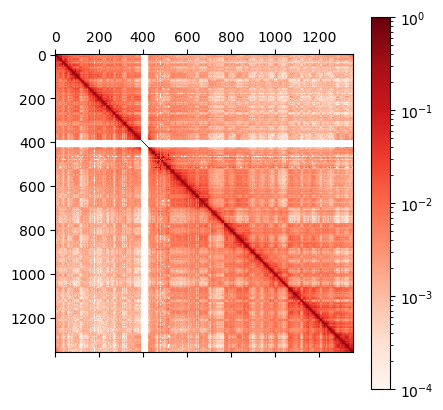

In [2]:
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r=np.triu(hic_file, k=1) 
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r=r+rd + np.diag(np.ones(len(r)))
print("number of beads: ", len(r))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds")  
plt.colorbar()

The Hi-C map has resolution of $100 kb$ per bead, so the chromosome 10 model has a polymer chain with a total of 1356 beads

The next step is to extract the sequence file (A/B sequence) by using the eigenvector decomposition. <br>

Using the juicertools you can extract the eigenvector file. The eigenvector has values both negatives and positives and here we will arbitrary set positives as A1 and negatives as B1. <br>

For more details about how it works, take a look on this paper: https://pubs.acs.org/doi/full/10.1021/acs.jpcb.1c04174

In [ ]:
%%bash
java -jar apps/juicer_tools_1.22.01.jar eigenvector -p Balanced https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 BP 100000 input/chr10_100k.eigen

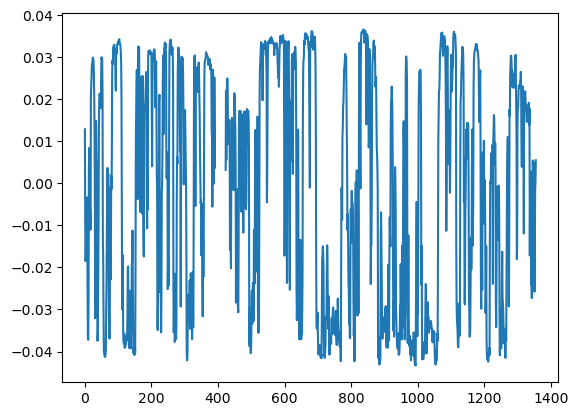

In [3]:
eigen = np.loadtxt("input/chr10_100k.eigen")
plt.plot(eigen)

From the .eigen file we can create the A/B sequence file.

In [ ]:
%%bash
awk '{if ($1 < 0) print "B1"; else print "A1"}' input/chr10_100k.eigen | cat -n > input/seq_chr10_100k.txt
head input/seq_chr10_100k.txt

The pipeline to perform the Types Potential Optimization is:

1. Run a long simulation using the homopolymer potential + customTypes potential. 
    The first iteration will start with all parameters equal to zero or a initial guess.

2. Get frames from this simualtion to perform the inversion for Types.

3. In the end of inversion, new values to types interactions will be produced.

4. Calcule the error between the simulated and experimental parameters. If the error is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15%).

The Types file is a `.txt` file with a matrix labeled with values for each interaction. In this tutorial, we will be training A1 and B1 type. <br> 

Lets create the initial file at this format:
<pre><code>
A1,B1
0,0
0,0
</pre></code>
For this matrix, we have AA AB BA BB interactions.

Save it as lambda_0.txt

In [ ]:
%%bash
echo "A1,B1
0,0
0,0" > input/lambda_0

cat input/lambda_0

With all the required inputs, lets perform a simulation for iteration 0

In MiChroM initiation there are some variables to setup:

**time_step=0.01** (the time step using for integration, default is 0.01)<br>
**temperature=1** (Set the temperature of your simulation)<br>
**name='opt_chr10_100K'** (the simulation name)<br>

In [4]:
sim = MiChroM(name='opt_chr10_100K',temperature=1.0, time_step=0.01)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.5 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

Now you need to setup the platform that you will use, the options are:

**platform="cuda"** (remember that you need to install CUDA in your system)<br>
**GPU="0" (optional)** (if you have more than one GPU device, you can set which gpu you want ["0", "1",...,"n"])<br>
**platform="cpu"**<br>
**platform="opencl"**<br>

In [5]:
sim.setup(platform="OpenCL")

Set the folder name where the output will be saved

In [6]:
sim.saveFolder('iteration_0')

The next step is to setup your chromosome sequence and initial configuration

In [7]:
mychro = sim.createSpringSpiral(ChromSeq="input/seq_chr10_100k.txt")

Load the initial structure into "sim" object

In [8]:
sim.loadStructure(mychro, center=True)

Now it is time to include the force field in the simulation object "sim"

Lets separate forces in two sets:

**Homopolymer Potentials**  

In [9]:
sim.addFENEBonds(kfb=30.0)
sim.addAngles(ka=2.0)
sim.addRepulsiveSoftCore(Ecut=4.0)

**Chromosome Potentials**

In this tutorial, it is used the CustomTypes potential. <br>
Here we need to pass a file that contains a matrix of interactions for each other different type of chromosome.
To check that, you can look on the documentation https://open-michrom.readthedocs.io/en/latest/OpenMiChroM.html#OpenMiChroM.ChromDynamics.MiChroM.addCustomTypes <br>

In [10]:
sim.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='input/lambda_0')

Note: these valeus for mu and rc were calculated for human GM12878 cells and can be changed for other species.

The last potential to be added is the spherical restraint in order to collapse the initial structure

In [11]:
sim.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

Now we will run a short simulation in order to get a collapsed structure.

There are two variables that control the chromosomes simulation steps:

**block:** The number of steps performed in each cycle (n_Blocks)<br>
**n_blocks:** The number of blocks that will be perfomed. <br>

In this example, to perfom the collapsing we will run $5\times10^2 \times  10^3 = 5\times10^5$ steps

In [12]:
block    = 500
n_blocks = 1000

We can save the radius of gyration of each block to observe the convergence into the collapsed state (the time required here depends on the size of your chromosome)

In [13]:
rg = []

In [ ]:
for _ in range(n_blocks):
    sim.runSimBlock(block, increment=False)
    rg.append(sim.chromRG())

#save a collapsed structure in pdb format for inspection
sim.saveStructure(mode = 'pdb')

Some details about the output for each block performed:

**bl=0** is the number of each block ran, in this case we set increment=False, so the number of steps is not accounted.<br>
**pos\[1\]=\[X,Y,Z\]** the spatial position for the first bead. <br>
**dr=1.26** show the average positions displacement in each block (in units os sigma). <br>
**t=0** the time step. in this case we set increment=False, so the number of steps is not accounted.<br>
**kin=1.5** is the kinect energy of the system.<br>
**pot=19.90** is the potential energy of the system. <br>
**RG=7.654** is the radius of gyration in the end of each block. <br>
**SPS=12312** is the steps per second of each block. A way to look how fast the computations are being performed.

Check the convergence of the radius of gyration:

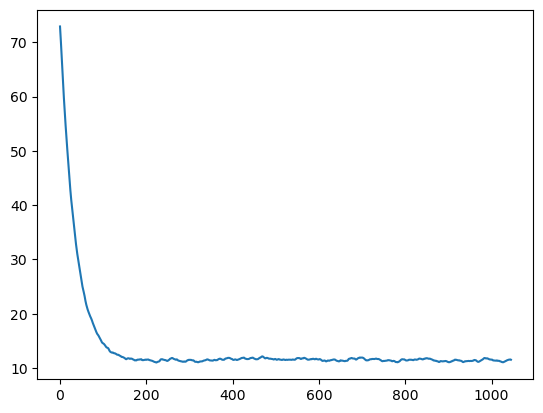

In [16]:
plt.plot(rg)

The next step is to remove the restraint force in order to run the sampling simulation

In [17]:
sim.removeFlatBottomHarmonic()

Initiate the optimization object. In this tutorial, this object is named "opt"

In [18]:
opt = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", TypesTable='input/lambda_0',
                            mu=3.22, rc = 1.78)

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from different replicas. For example, $20$ replicas of $5000$ saved frames. <br> 

This can take some time, so in this tutorial we will use just 1 replica of $5000$ frames saved every $1000$ steps. <br>

    block = 1000
    n_blocks = 5000

In [19]:
block    = 1000
n_blocks = 5000

In [ ]:
for _ in range(n_blocks):
    # perform 1 block of the simulation
    sim.runSimBlock(block, increment=True) 
    # feed the optimization with the last position 
    opt.probCalculation_types(sim.getPositions())

In the end of each replica simulation we need to save some important values required to calculate the inversion. <br>

We are saving these files using the H5 compression because it is faster to write/read. <br>

Note: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [21]:
replica=1

with h5py.File(sim.folder + "/polds_type_" + str(replica)+".h5", 'w') as hf:
    hf.create_dataset("polds_type",  data=opt.polds_type)

with h5py.File(sim.folder + "/Bij_type_" + str(replica)+".h5", 'w') as hf:
    hf.create_dataset("Bij_type",  data=opt.Bij_type)

with h5py.File(sim.folder + "/Nframes_" + str(replica)+".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=opt.Nframes)

with h5py.File(sim.folder + "/Pold_" + str(replica)+".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=opt.Pold)

The first part of the optimization is finished. Inside the output folder, for each iteration, there are these 4 files used in next step.

In [22]:
%%bash
ls iteration_0/*.h5

iteration_0/Bij_type_1.h5
iteration_0/Nframes_1.h5
iteration_0/Pold_1.h5
iteration_0/polds_type_1.h5


The second part is the inversion, it is quite simple, just feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [23]:
opt2 = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", TypesTable='input/lambda_0',
                            mu=3.22, rc = 1.78)

In [24]:
iterations = "iteration_0"
replicas=[1]
for replica in replicas:
    with h5py.File(iterations + "/polds_type_" + str(replica)+".h5", 'r') as hf:
        opt2.polds_type += hf['polds_type'][:]

    with h5py.File(iterations + "/Bij_type_" + str(replica)+".h5", 'r') as hf:
        opt2.Bij_type += hf['Bij_type'][:]

    with h5py.File(iterations + "/Nframes_" + str(replica)+".h5", 'r') as hf:
        opt2.Nframes +=hf['Nframes'][()]

    with h5py.File(iterations + "/Pold_" + str(replica)+".h5", 'r') as hf:
        opt2.Pold += hf['Pold'][:]
    

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 

In [25]:
damp = 3*10**-7 
lambdas = opt2.getLamb_types(exp_map="input/chr10_100k.dense", damp=damp)
print(lambdas)  

         A1        B1
0 -0.423845 -0.475924
1 -0.475924 -0.212862


Save the new lambda (`lambda_1`) and other files to analyze the inversion.

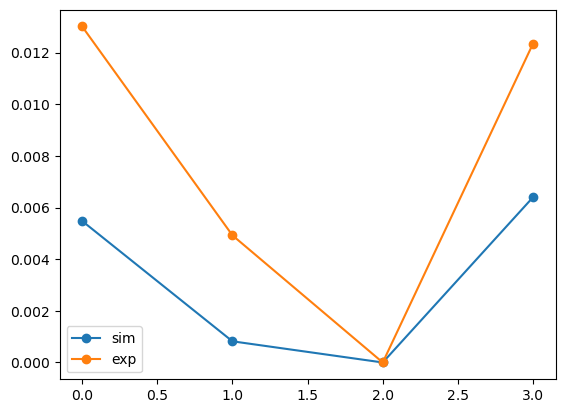

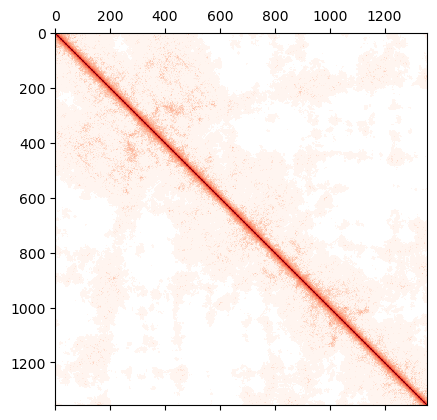

In [26]:
iteration = 0
#prob of A/B in sim and exp
phi_sim = opt2.calc_sim_phi_types().ravel()
phi_exp = opt2.calc_exp_phi_types().ravel()
np.savetxt('phi_sim_' + str(iteration), phi_sim)
np.savetxt('phi_exp', phi_exp)

plt.plot(phi_sim, 'o-', label="sim")
plt.plot(phi_exp, 'o-', label="exp")
plt.legend()

#HiC_simulate
dense_sim = opt2.getHiCSim()
np.savetxt('hic_sim_' + str(iteration)+'.dense', dense_sim)
plt.matshow(dense_sim, norm=mpl.colors.LogNorm(vmin=0.0001, vmax=dense_sim.max()),cmap="Reds")

#save the new lambda file
lambdas.to_csv("input/lambda_1", index=False)

Redo these steps using the new lambda file (`lambda_1`) as input for Types potential in the next iteration. 

The error can be calculate using phi_sim_1 and phi_exp by the equation:<br>

$error = \frac{|\phi_{sim}-\phi_{exp}|}{\phi_{exp}}$

This is appended in the file  `error_and_pearsonC_types`.

In [27]:
%%bash
cat error_and_pearsonC_types

Error: 0.621143  Pearson's Correlation: 0.853857


We included a folder named `scripts` that has some `.py` and `.slurm` files that can be used to run this optimization in parallel using slurm clusters. 